In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import scipy.stats as spstats
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 80

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import DGM

# Deep Galerkin Method Solutions of the Wave Equation

An extension of **DGM: A deep learning algorithm for solving partial diﬀerential equations** 

<br>

Bilal Saleh Husain, 2024-25

<br>

### Equation, Simulation, & DGM Parameters

In [2]:
# Domain parameters
r_min = 0        # Left boundary (fixed end)
r_max = 10       # Right boundary (fixed end)
T = 10.0          # Total simulation time
c = 1.0           # Wave speed (set to 1 for simplicity)

# Network parameters
layer_width = 50   # Neurons per hidden layer
n_layers = 3       # Number of LSTM layers

In [3]:
# Training parameters
sampling_stages = 1000
steps_per_sample = 20
learning_rate = 0.0001
nSim_interior = 1000    # Collocation points for PDE
nSim_IC = 1000          # Initial condition points
nSim_BC = 1000          # Boundary condition points

choice_initial_I = 'gaussian'    # 'gaussian' or 'sine'
choice_initial_II = 'zero'       # 'zero' or 'dgaussian'

### Initial Conditions and Exact Solutions

In [4]:
# sinusodal initial condition  

A = 2
L = r_max - r_min
n = 3

def sine_initial(r, L, n, A):
    return A * torch.sin(n * np.pi * r / L)

def sine_exact_solution(t, r, n, L, c, A):
    return A * np.sin(n * np.pi * r / L) * np.cos(n * np.pi * c * t / L)

In [5]:
# gaussian initial condition  

mean = L/2   # Center of domain
sd = L/10    # Width of Gaussian
A = 2.0      # Peak amplitude
c = 1.0      # Wave speed

def gaussian_initial(r, mean, sd, A):
    return A * torch.exp(-0.5 * ((r - mean) / sd)**2)  

def initial_velocity(r, mean, sd, c, A):
    return (c * A * (r - mean) / sd**2) * torch.exp(-0.5 * ((r - mean) / sd)**2)

In [6]:
def initial_condition_I(r):
    if choice_initial_I == 'gaussian': 
        return gaussian_initial(r, mean=mean, sd=sd, A=A)
    if choice_initial_I == 'sine': 
        return sine_initial(r, L=L, n=n, A=A)

def initial_condition_II(r):
    if choice_initial_II == 'zero': 
        return 0
    if choice_initial_II == 'dgaussian': 
        return initial_velocity(r, mean=mean, sd=sd, c=c, A=A)

def exact_solution(t, r):
    return sine_exact_solution(t, r, n=n, L=L, c=c, A=A)

### Crank-Nicolson Schemes

#### Gaussian I ($v_0 = 0$)

In [7]:
# Parameters
c = 1.0  # wave speed
nx, nt = 600, 600  # spatial and temporal points

# Spatial and temporal grids
r_vals = np.linspace(r_min, r_max, nx)
t_vals = np.linspace(0, T, nt)
dr = r_vals[1] - r_vals[0]
dt = t_vals[1] - t_vals[0]

# Crank-Nicolson parameters
alpha = (c * dt / dr)**2

# Initial condition
def gaussian_initial(r):
    return A * np.exp(-0.5 * ((r - mean) / sd)**2)

# Initialize solution array
u = np.zeros((nt, nx))
u[0, :] = gaussian_initial(r_vals)
u[1, :] = u[0, :]  # Zero initial velocity (du/dt = 0)

# Crank-Nicolson scheme
for n in range(1, nt-1):
    # Create tridiagonal system
    main_diag = np.ones(nx) * (1 + alpha)
    off_diag = np.ones(nx-1) * (-alpha/2)
    
    A = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1)
    
    # Boundary conditions (Dirichlet)
    A[0, 0] = 1; A[0, 1] = 0
    A[-1, -1] = 1; A[-1, -2] = 0
    
    # Right-hand side
    rhs = np.zeros(nx)
    rhs[1:-1] = (2 - alpha)*u[n, 1:-1] + (alpha/2)*(u[n, :-2] + u[n, 2:]) - u[n-1, 1:-1]
    rhs[0] = 0; rhs[-1] = 0  # Boundary conditions
    
    # Solve system
    u[n+1, :] = np.linalg.solve(A, rhs)

KeyboardInterrupt: 

<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
/var/folders/f5/zrq5v0pn2tdds7046k_0mwxh0000gn/T/ipykernel_71130/3369491482.py:6: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('Amplitude ($\phi$)', fontsize=12)
/var/folders/f5/zrq5v0pn2tdds7046k_0mwxh0000gn/T/ipykernel_71130/3369491482.py:6: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('Amplitude ($\phi$)', fontsize=12)


ValueError: '' is not a valid value for color: supported inputs are (r, g, b) and (r, g, b, a) 0-1 float tuples; '#rrggbb', '#rrggbbaa', '#rgb', '#rgba' strings; named color strings; string reprs of 0-1 floats for grayscale values; 'C0', 'C1', ... strings for colors of the color cycle; and pairs combining one of the above with an alpha value

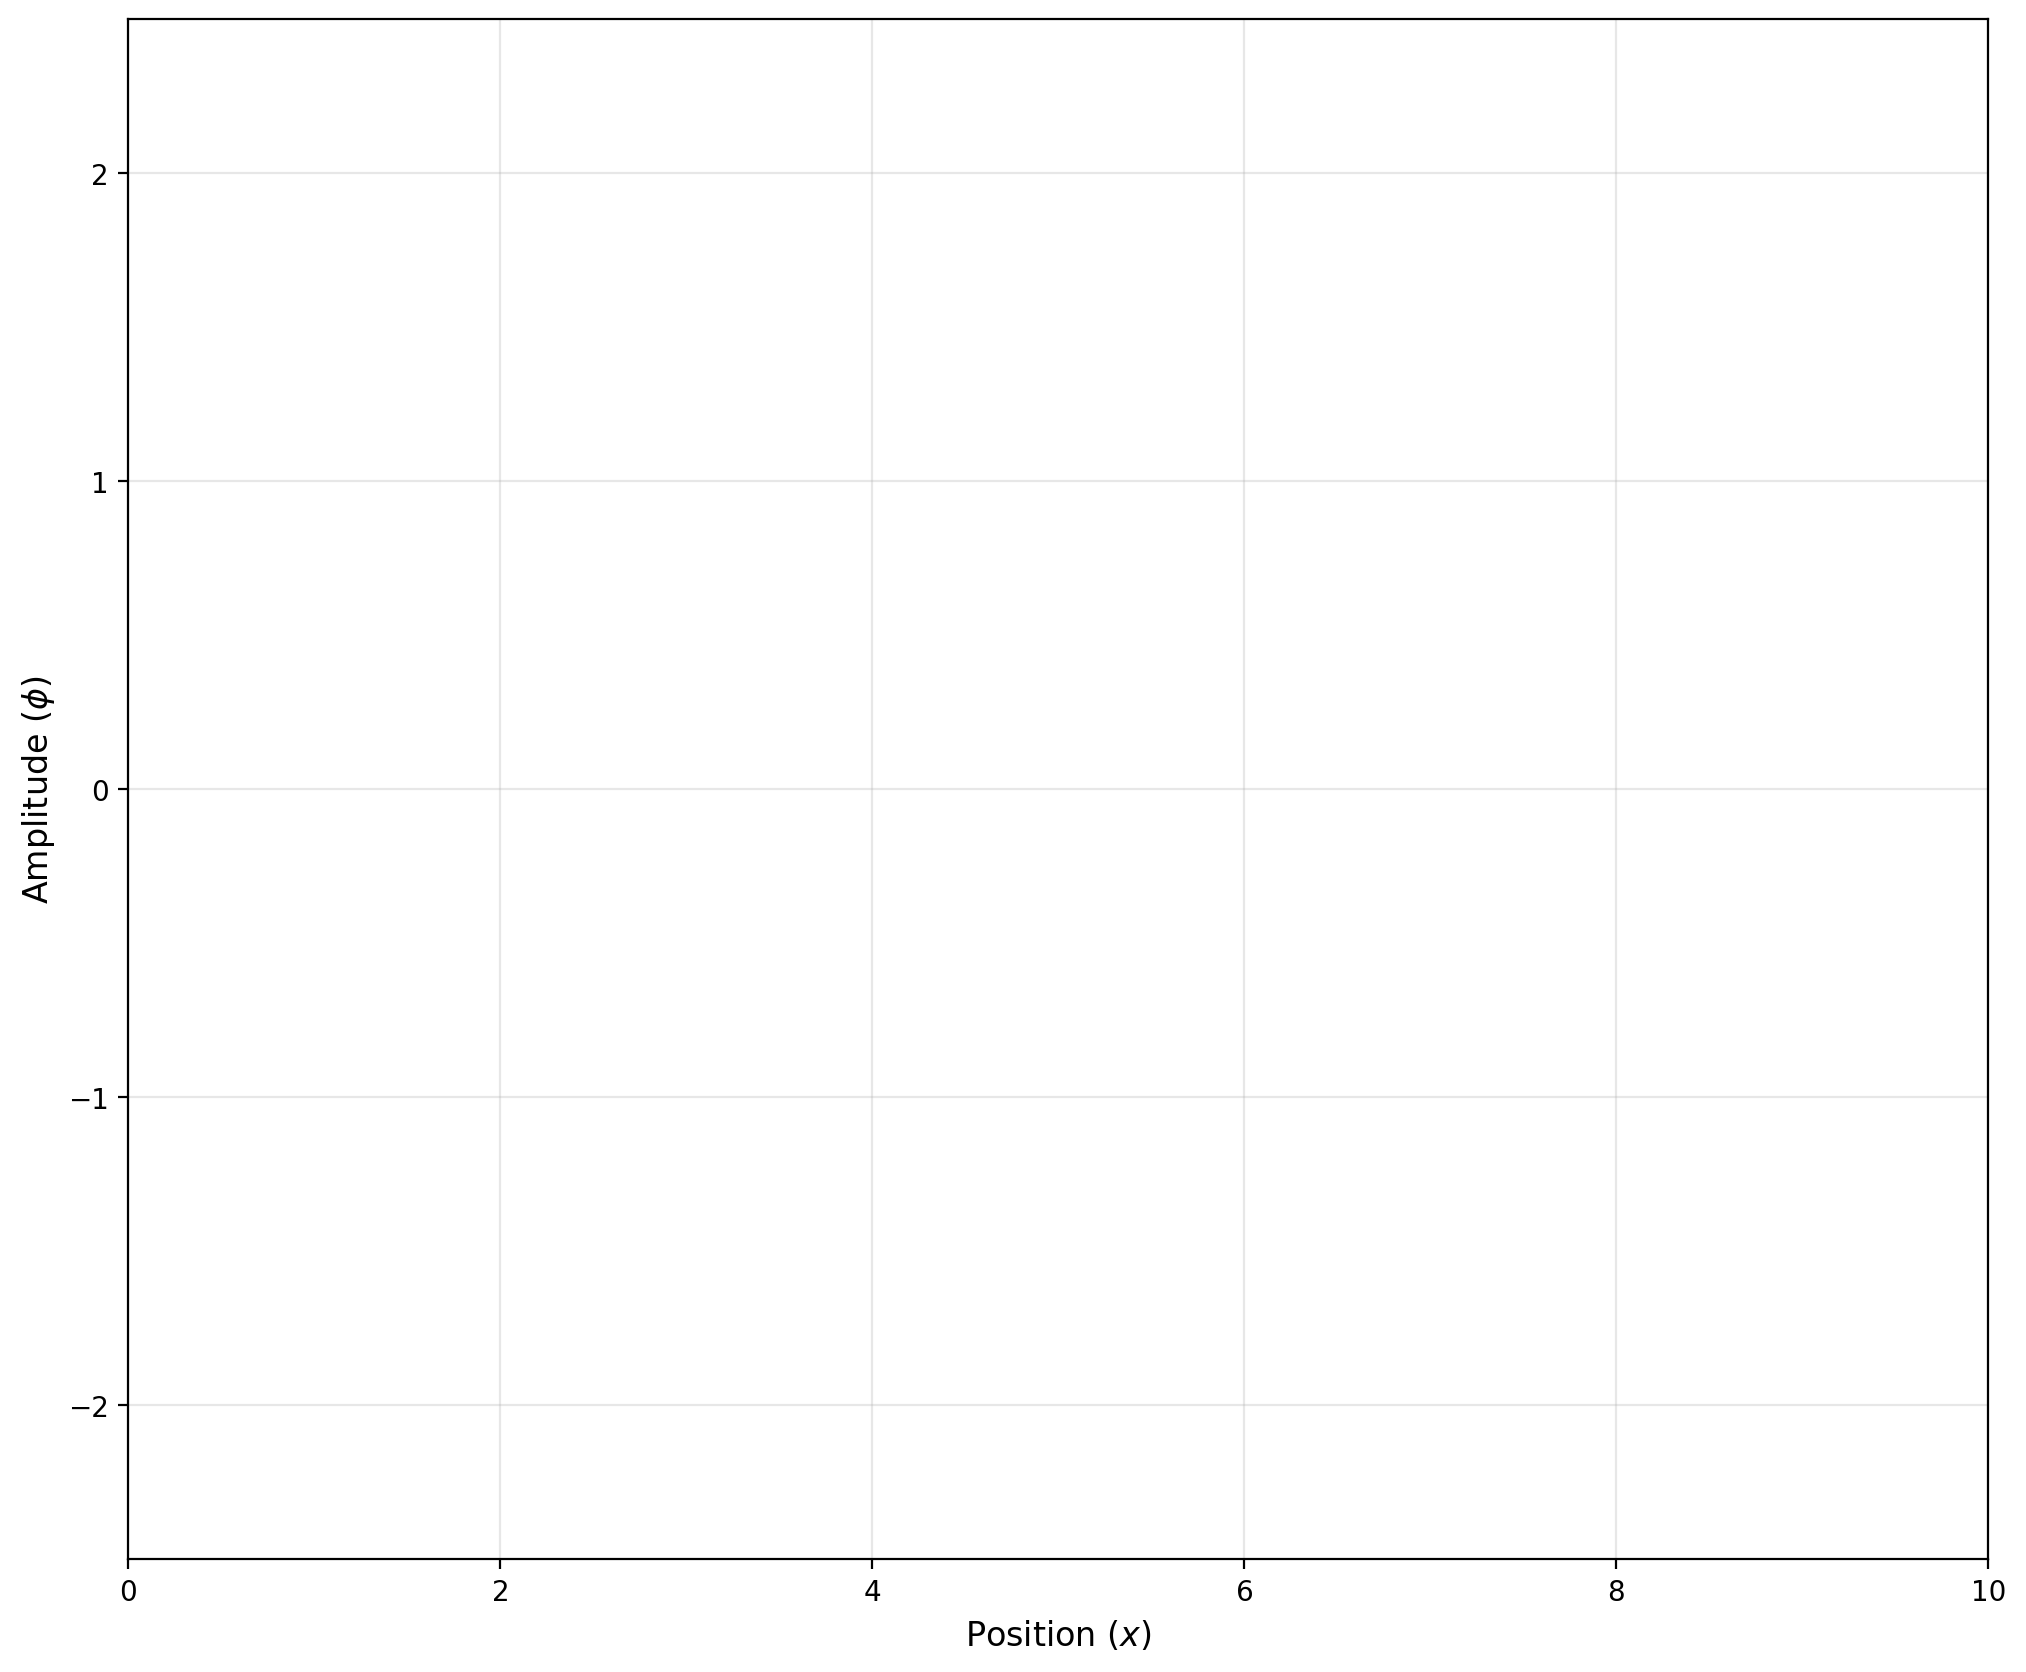

In [8]:
# Create figure for comparison
fig, ax = plt.subplots(figsize=(12, 10), dpi=200)
ax.set_xlim(r_min, r_max)
ax.set_ylim(-2.5, 2.5)
ax.set_xlabel('Position ($x$)', fontsize=12)
ax.set_ylabel('Amplitude ($\phi$)', fontsize=12)
ax.grid(alpha=0.3)

# Initialize lines
line_dgm, = ax.plot([], [], 'r-', lw=2, label='DGM Approximation')
line_cn, = ax.plot([], [], linestyle=':', color='', lw=2, label='Crank-Nicolson')
ax.legend(loc='upper right')

# For DGM solution (assuming you have a trained model)
solutions_dgm = []
with torch.no_grad():
    for t in t_vals:
        t_tensor = torch.full((len(r_vals), 1), t, dtype=torch.float32)
        r_tensor = torch.tensor(r_vals.reshape(-1, 1), dtype=torch.float32)
        phi_dgm = model(t_tensor, r_tensor)[:, 0].numpy()
        solutions_dgm.append(phi_dgm)


# Animation function
def animate(i):
    line_dgm.set_data(r_vals, solutions_dgm[i])
    line_cn.set_data(r_vals, u[i, :])
    ax.set_title(f't = {t_vals[i]:.2f}')
    return line_cn, line_dgm,

# Create animation
ani = FuncAnimation(fig, animate, frames=len(t_vals), interval=100, blit=True)

# Save and display
#ani.save('1D_Wave_Equation_Gaussian_I_initial.gif', writer='pillow', fps=100, dpi=200)
plt.close()
HTML(ani.to_jshtml())

#### Gaussian II ($v_0 = \phi'$)

##### Crank-Nicolson

In [9]:
# Parameters
c = 1.0  # wave speed
nx, nt = 1000, 1000  # spatial and temporal points

# Spatial and temporal grids
r_vals = np.linspace(r_min, r_max, nx)
t_vals = np.linspace(0, 20, nt)
dr = r_vals[1] - r_vals[0]
dt = t_vals[1] - t_vals[0]

# Crank-Nicolson stability parameter
alpha = (c * dt / dr)**2

# Initial conditions
def gaussian_initial(r):
    return A * np.exp(-0.5 * ((r - mean) / sd)**2)

def initial_velocity(r):
    return (c * A * (r - mean) / sd**2) * np.exp(-0.5 * ((r - mean) / sd)**2)

# Initialize solution array
u = np.zeros((nt, nx))
u[0, :] = gaussian_initial(r_vals)
# First time step using initial velocity
u[1, :] = u[0, :] + dt * initial_velocity(r_vals)  # Now includes initial velocity

# Crank-Nicolson scheme
for n in range(1, nt-1):
    # Create tridiagonal system
    main_diag = np.ones(nx) * (1 + alpha)
    off_diag = np.ones(nx-1) * (-alpha/2)
    
    A = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1)
    
    # Boundary conditions (Dirichlet)
    A[0, 0] = 1; A[0, 1] = 0
    A[-1, -1] = 1; A[-1, -2] = 0
    
    # Right-hand side
    rhs = np.zeros(nx)
    rhs[1:-1] = (2 - alpha)*u[n, 1:-1] + (alpha/2)*(u[n, :-2] + u[n, 2:]) - u[n-1, 1:-1]
    rhs[0] = 0; rhs[-1] = 0  # Boundary conditions
    
    # Solve system
    u[n+1, :] = np.linalg.solve(A, rhs)

ValueError: operands could not be broadcast together with shapes (600,600) (1000,) 

##### Plotting

<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
/var/folders/f5/zrq5v0pn2tdds7046k_0mwxh0000gn/T/ipykernel_71130/1126385453.py:5: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('Amplitude ($\phi$)', fontsize=12)
/var/folders/f5/zrq5v0pn2tdds7046k_0mwxh0000gn/T/ipykernel_71130/1126385453.py:5: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('Amplitude ($\phi$)', fontsize=12)


NameError: name 'model' is not defined

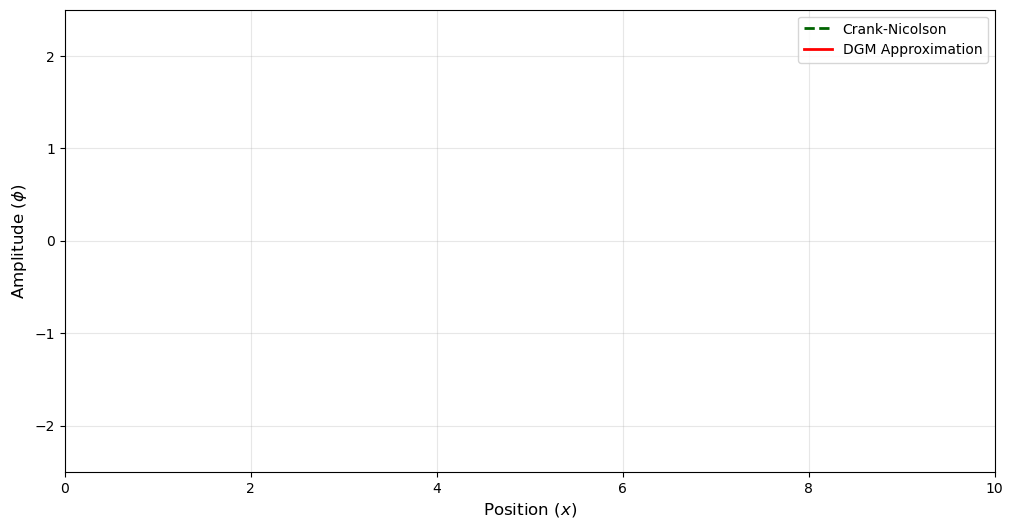

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlim(r_min, r_max)
ax.set_ylim(-2.5, 2.5)
ax.set_xlabel('Position ($x$)', fontsize=12)
ax.set_ylabel('Amplitude ($\phi$)', fontsize=12)
ax.grid(alpha=0.3)

# Initialize lines
line_cn, = ax.plot([], [], linestyle='--', color='darkgreen', lw=2, label='Crank-Nicolson')
line_dgm, = ax.plot([], [], 'r-', lw=2, label='DGM Approximation')
ax.legend(loc='upper right')

# For DGM solution (assuming you have a trained model)
solutions_dgm = []
with torch.no_grad():
    for t in t_vals:
        t_tensor = torch.full((len(r_vals), 1), t, dtype=torch.float32)
        r_tensor = torch.tensor(r_vals.reshape(-1, 1), dtype=torch.float32)
        phi_dgm = model(t_tensor, r_tensor)[:, 0].numpy()
        solutions_dgm.append(phi_dgm)

# Animation function
def animate(i):
    line_dgm.set_data(r_vals, solutions_dgm[i])
    line_cn.set_data(r_vals, u[i, :])
    ax.set_title(f't = {t_vals[i]:.2f}')
    return line_cn, line_dgm,

# Create animation
ani = FuncAnimation(fig, animate, frames=len(t_vals), interval=50, blit=True)

# Save and display
#ani.save('wave_animation_with_velocity.gif', writer='pillow', fps=20, dpi=100)
plt.close()
HTML(ani.to_jshtml())

<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
/var/folders/f5/zrq5v0pn2tdds7046k_0mwxh0000gn/T/ipykernel_44514/1801662554.py:27: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$\phi$', fontsize=10)


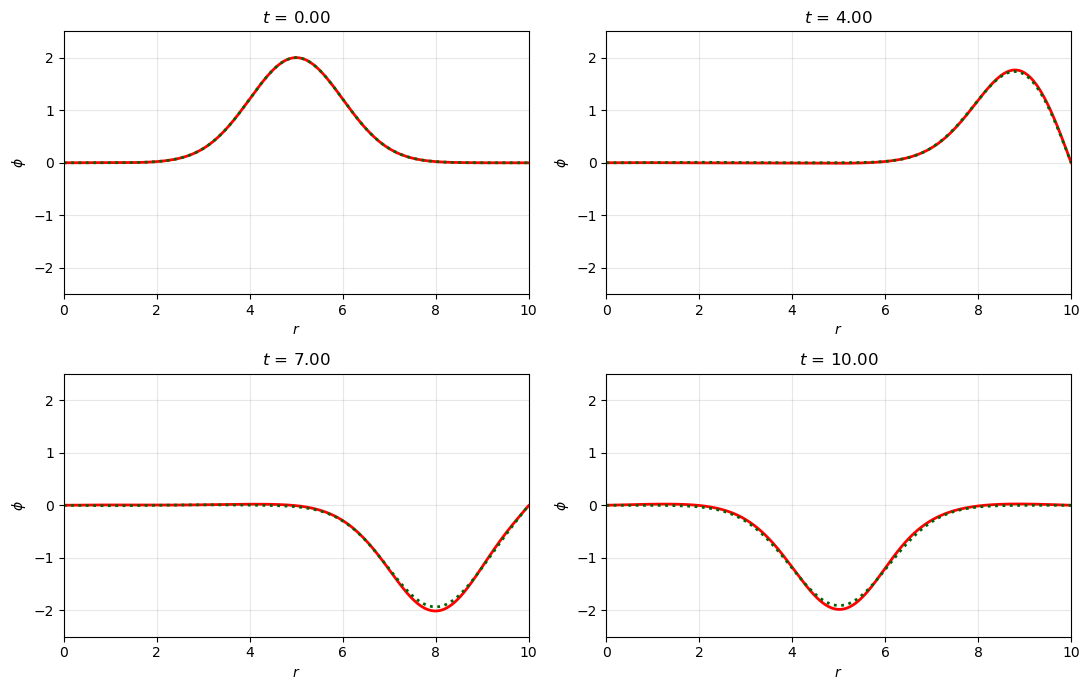

In [304]:
# Define the specific times you want to plot
selected_times = [0, 4, 7, 10]  # Example times - adjust to your needs

# Create figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(11,7))

# Flatten the axes array for easier iteration
axs = axs.ravel()

# Find the closest time indices in your t_vals array
time_indices = [np.argmin(np.abs(t_vals - t)) for t in selected_times]

# Plot solutions at each selected time
for i, (idx, t) in enumerate(zip(time_indices, selected_times)):
    ax = axs[i]
    
    # Plot DGM solution
    ax.plot(r_vals, solutions_dgm[idx], 'r-', lw=2, label='DGM Approximation')

    # Plot Crank-Nicolson solution
    ax.plot(r_vals, u[idx, :], ':', color='darkgreen', lw=2, label='Crank-Nicolson')
    
    # Set plot properties
    ax.set_xlim(r_min, r_max)
    ax.set_ylim(-2.5, 2.5)
    ax.set_xlabel('$r$', fontsize=10)
    ax.set_ylabel('$\phi$', fontsize=10)
    ax.set_title(f'$t$ = {t:.2f}', fontsize=12)
    ax.grid(alpha=0.3)
    #ax.legend(loc='upper right')

plt.tight_layout()
fig.savefig('1D_Wave_Equation_Gaussian_II', dpi=300, bbox_inches='tight')
plt.show()

### Sampler & Loss Function

In [11]:
# Sampling function (same as before, but for r ∈ [r_min, r_max])
def sampler(nSim_interior, nSim_IC, nSim_BC):
    t_interior = np.random.uniform(0, T, (nSim_interior, 1))
    r_interior = np.random.uniform(r_min, r_max, (nSim_interior, 1))
    
    t_IC = np.zeros((nSim_IC, 1))
    r_IC = np.random.uniform(r_min, r_max, (nSim_IC, 1))
    
    t_BC = np.random.uniform(0, T, (nSim_BC, 1))
    r_BC = np.random.choice([r_min, r_max], (nSim_BC, 1))
    
    return (t_interior, r_interior), (t_IC, r_IC), (t_BC, r_BC)

In [12]:
def loss(model, t_interior, r_interior, t_IC, r_IC, t_BC, r_BC):
    # PDE Loss
    phi = model(t_interior, r_interior)
    phi_t = torch.autograd.grad(phi.sum(), t_interior, create_graph=True)[0]
    phi_r = torch.autograd.grad(phi.sum(), r_interior, create_graph=True)[0]
    phi_tt = torch.autograd.grad(phi_t.sum(), t_interior, create_graph=True)[0]
    phi_rr = torch.autograd.grad(phi_r.sum(), r_interior, create_graph=True)[0]
    L_PDE = torch.mean((phi_tt - phi_rr)**2)  
    
    # Initial Conditions
    phi_IC = model(t_IC, r_IC)
    phi0_I = initial_condition_I(r_IC)
    phi0_II = initial_condition_II(r_IC)
    
    phi_t_IC = torch.autograd.grad(phi_IC.sum(), t_IC, create_graph=True)[0]
    L_IC = torch.mean((phi_IC - phi0_I)**2 + (phi_t_IC - phi0_II)**2)
    
    # Boundary Conditions (Dirichlet)
    phi_BC = model(t_BC, r_BC)
    L_BC = torch.mean(phi_BC**2)
    
    return L_PDE, L_IC, L_BC

### Model Training

In [13]:
model = DGM.DGMNet(layer_width, n_layers, input_dim=1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for i in range(sampling_stages):

    interior_points, IC_points, BC_points = sampler(nSim_interior, nSim_IC, nSim_BC)
    
    t_interior = torch.tensor(interior_points[0], dtype=torch.float32, requires_grad=True)
    r_interior = torch.tensor(interior_points[1], dtype=torch.float32, requires_grad=True)
    t_IC = torch.tensor(IC_points[0], dtype=torch.float32, requires_grad=True) 
    r_IC = torch.tensor(IC_points[1], dtype=torch.float32)
    t_BC = torch.tensor(BC_points[0], dtype=torch.float32)
    r_BC = torch.tensor(BC_points[1], dtype=torch.float32)
    
    for _ in range(steps_per_sample):
        optimizer.zero_grad()
        
        # Compute losses
        L_PDE, L_IC, L_BC = loss(model, t_interior, r_interior, t_IC, r_IC, t_BC, r_BC)
        total_loss = L_PDE + L_IC + L_BC
        
        total_loss.backward()
        optimizer.step()
    
    print(f"Iter {i}, Loss: {total_loss.item():.2e}, "
          f"PDE: {L_PDE.item():.1e}, IC: {L_IC.item():.1e}, BC: {L_BC.item():.1e}")

TypeError: gaussian_initial() got an unexpected keyword argument 'mean'

### Plotting

<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\p'
/var/folders/f5/zrq5v0pn2tdds7046k_0mwxh0000gn/T/ipykernel_71130/285139019.py:13: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('Amplitude ($\phi$)', fontsize=12)
/var/folders/f5/zrq5v0pn2tdds7046k_0mwxh0000gn/T/ipykernel_71130/285139019.py:13: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('Amplitude ($\phi$)', fontsize=12)


ValueError: operands could not be broadcast together with shapes (600,600) (200,) 

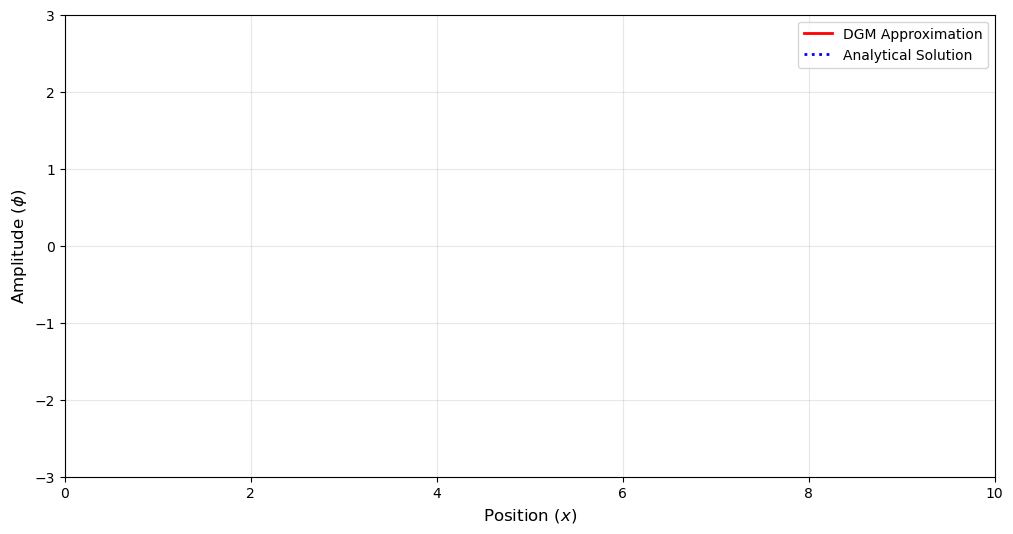

In [14]:
t_f = 10

# Set up the spatial grid and time points
r_vals = np.linspace(r_min, r_max, 200)
t_vals = np.linspace(0, t_f, 200)

# Create figure with two lines
fig, ax = plt.subplots(figsize=(12, 6)) #, dpi=200)

ax.set_xlim(r_min, r_max)
ax.set_ylim(-3, 3)  # Adjusted to fit both solutions
ax.set_xlabel('Position ($x$)', fontsize=12)
ax.set_ylabel('Amplitude ($\phi$)', fontsize=12)
ax.grid(alpha=0.3)

# Initialize lines
line_nn, = ax.plot([], [], 'r-', lw=2, label='DGM Approximation')
line_exact, = ax.plot([], [], 'b:', lw=2, label='Analytical Solution')
ax.legend(loc='upper right')

# Pre-compute solutions
solutions_nn = []
solutions_exact = []

with torch.no_grad():
    for t in t_vals:
        # Neural network solution
        t_tensor = torch.full((len(r_vals), 1), t, dtype=torch.float32)
        r_tensor = torch.tensor(r_vals.reshape(-1, 1), dtype=torch.float32)
        phi_nn = model(t_tensor, r_tensor)[:, 0].numpy()
        solutions_nn.append(phi_nn)
        
        # Exact solution
        phi_exact = exact_solution(t, r_vals)
        solutions_exact.append(phi_exact)

# Animation function
def animate(i):
    line_nn.set_data(r_vals, solutions_nn[i])
    line_exact.set_data(r_vals, solutions_exact[i])
    ax.set_title(f't = {t_vals[i]:.2f}')
    return line_nn, line_exact,

# Create animation
ani = FuncAnimation(fig, animate, frames=len(t_vals), interval=50, blit=True)

#ani.save('1D_Wave_Equation_sine_initial.gif', writer='pillow', fps=50, dpi=200)

# Display in notebook
plt.close()
HTML(ani.to_jshtml())

<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
/var/folders/f5/zrq5v0pn2tdds7046k_0mwxh0000gn/T/ipykernel_68232/977579109.py:27: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$\phi$', fontsize=10)


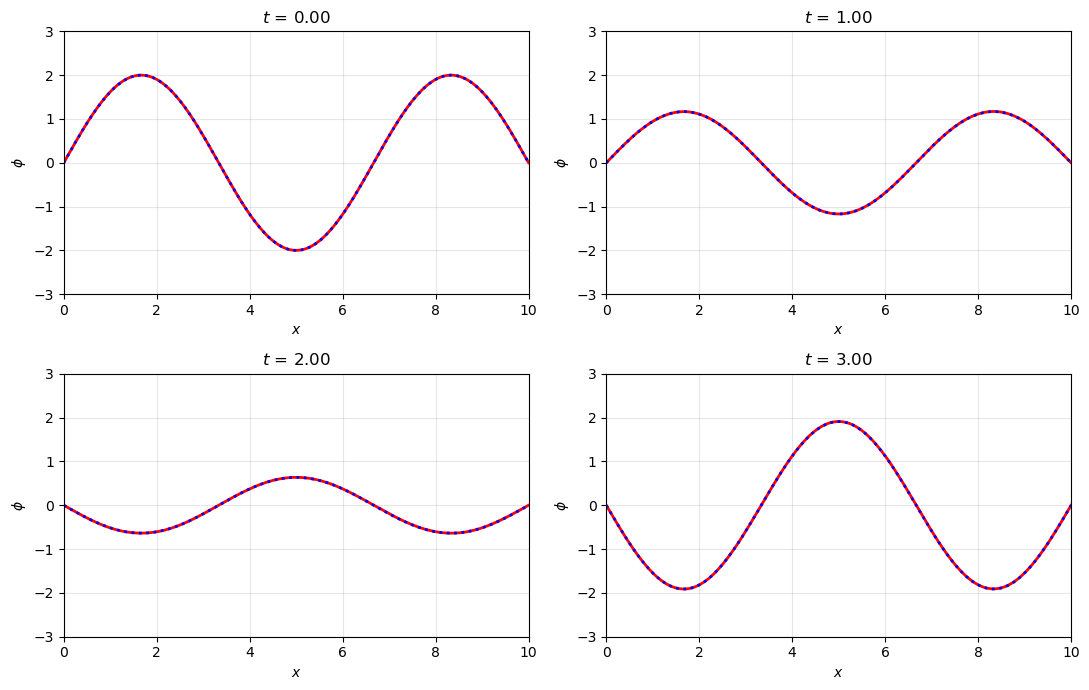

In [15]:
selected_times = [0, 1, 2, 3]  

# Create figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(11, 7), dpi=100)

axs = axs.ravel()

# Find the closest time indices in t_vals array
time_indices = [np.argmin(np.abs(t_vals - t)) for t in selected_times]

# Plot solutions at each selected time
for i, (idx, t) in enumerate(zip(time_indices, selected_times)):
    ax = axs[i]
    
    # Plot Neural Network solution
    ax.plot(r_vals, solutions_nn[idx], 'r-', lw=2, label='DGM Approximation')
    
    # Plot Exact solution
    ax.plot(r_vals, solutions_exact[idx], 'b:', lw=2, label='Analytical Solution')
    
    ax.set_xlim(r_min, r_max)
    ax.set_ylim(-3, 3)  
    ax.set_xlabel('$x$', fontsize=10)
    ax.set_ylabel('$\phi$', fontsize=10)
    ax.set_title(f'$t$ = {t:.2f}', fontsize=12)
    ax.grid(alpha=0.3)
    
plt.tight_layout()

#fig.savefig('1D_Wave_Equation_sine.png', dpi=300, bbox_inches='tight', facecolor='white')

plt.show()

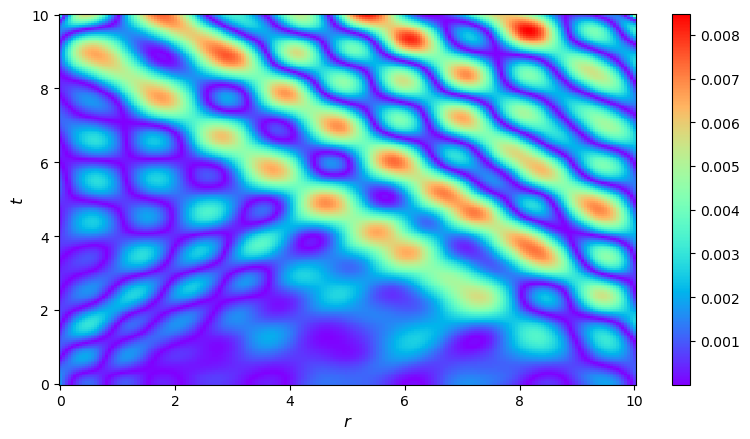

In [17]:
# Compute absolute error
abs_error = np.abs(np.array(solutions_nn) - np.array(solutions_exact))

# Create time and space grids for plotting
R, T = np.meshgrid(r_vals, t_vals)

# Create figure
plt.figure(figsize=(8, 4.5))

# Plot heatmap - use pcolormesh for irregular grids if needed
heatmap = plt.pcolormesh(R, T, abs_error, 
                        shading='auto', 
                        cmap='rainbow')  # Or 'plasma'/'inferno' for higher contrast

# Add colorbar
cbar = plt.colorbar(heatmap)

# Add labels and title
plt.xlabel('$r$', fontsize=12)
plt.ylabel('$t$', fontsize=12)

# Adjust layout and save
plt.tight_layout()
plt.savefig('1D_Error_sine2.png', dpi=300, bbox_inches='tight')

plt.show()

### Model Saving

In [449]:
torch.save(model.state_dict(), 'weight_wvhrgbrw_initial.pth')

# Load (requires architecture to be defined first)
#model = YourModelClass()  # Re-initialize the model
#model.load_state_dict(torch.load('weights.pth'))
#model.eval()

In [5]:
model = DGM.DGMNet(layer_width, n_layers, input_dim=1)  # Re-initialize the model
model.load_state_dict(torch.load('Saved Weights/1D_sine_initial.pth'))

model.eval()

/var/folders/f5/zrq5v0pn2tdds7046k_0mwxh0000gn/T/ipykernel_68232/2548584112.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Saved Weigh

DGMNet(
  (initial_layer): DenseLayer()
  (LSTMLayerList): ModuleList(
    (0-2): 3 x LSTMLayer()
  )
  (final_layer): DenseLayer()
)